Задание:

В документе предоставлены реальные сырые данные по рекламному заработку первых 7-ми дней
жизни пользователей, установивших игру 01.09.2024.

На основе имеющихся данных предоставьте в удобном для вас формате прогноз рекламного
заработка до 30.09.2024.

Во сколько раз накопительный доход к 30-му дню будет больше дохода в день установки игры?

Пояснение к таблицe:

Лист ad revenue(данные по рекламному заработку):

Install_date - дата установки игры пользователем

Event_date - дата совершения события

Event_revenue - рекламный заработок

User_id - уникальный идентификатор пользователя

Имортируем необходимые для работы библиотеки

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

Считываем файл, перводим его в формат датафрейма для более удобной работы

In [168]:
df = pd.read_csv(r'C:\Users\Julia\Downloads\Ad revenue - ad revenue.csv')
pd.DataFrame(data = df)

,install_date,event_date,event_revenue,user_id
0,2024-09-01,2024-09-01,0.128428,28add615-1760-42a1-bb2e-f25d831d18e7
1,2024-09-01,2024-09-01,0.025017,c1680ba0-5b74-408d-a573-06ca1ad3f502
2,2024-09-01,2024-09-01,0.047368,5f80f606-a748-43ff-9356-88ca9b41cbd3
3,2024-09-01,2024-09-01,0.053080,3b592e6d-f35a-4715-9cf3-9b7a63336c24
4,2024-09-01,2024-09-01,0.023026,c1680ba0-5b74-408d-a573-06ca1ad3f502
...,...,...,...,...
89569,2024-09-01,2024-09-07,0.008747,290aec44-284b-450c-8a56-610d51faf98e
89570,2024-09-01,2024-09-07,0.003559,2139196a-f844-4d04-9467-6ac9c9564d33
89571,2024-09-01,2024-09-07,0.004110,0709ac8b-58d0-4e49-a304-d31a726c5330
89572,2024-09-01,2024-09-07,0.034042,c69234b4-edb0-4024-84ae-53a6ccf6b46b


Изучим данные: преобразуем типы данных, проверим пропуски, дубли.

In [169]:
df.dtypes

install_date      object
event_date        object
event_revenue    float64
user_id           object
dtype: object

Переведем столцы с датой в формат datetime

In [170]:
df.install_date = pd.to_datetime(df.install_date)
df.event_date = pd.to_datetime(df.event_date)

In [171]:
df.duplicated().sum()

np.int64(7004)

Видим, что в датафрейме 7004 одинаковых строк, но удалять их не станем, так как пользователь мог в один и тот же день совершить несколько покупок на однуу сумму. К сожалению, у нас нет номера транзакции или точного времени с секундами, чтобы сделать точные выводы, поэтому оставим, как есть.

In [172]:
df.isna().sum()

install_date     0
event_date       0
event_revenue    0
user_id          0
dtype: int64

Пропусков нет.

In [173]:
df.describe()

,install_date,event_date,event_revenue
count,89574,89574,89574.000000
mean,2024-09-01 00:00:00,2024-09-02 20:13:04.191841280,0.029325
min,2024-09-01 00:00:00,2024-09-01 00:00:00,0.000014
25%,2024-09-01 00:00:00,2024-09-01 00:00:00,0.007204
50%,2024-09-01 00:00:00,2024-09-02 00:00:00,0.014948
75%,2024-09-01 00:00:00,2024-09-04 00:00:00,0.030980
max,2024-09-01 00:00:00,2024-09-07 00:00:00,1.473103
std,NaN,NaN,0.054141


Рассчитаем количество дней с момента установки

In [186]:
df['days_since_install'] = (df.event_date - df.install_date).dt.days
df

,install_date,event_date,event_revenue,user_id,days_since_install
0,2024-09-01,2024-09-01,0.128428,28add615-1760-42a1-bb2e-f25d831d18e7,0
1,2024-09-01,2024-09-01,0.025017,c1680ba0-5b74-408d-a573-06ca1ad3f502,0
2,2024-09-01,2024-09-01,0.047368,5f80f606-a748-43ff-9356-88ca9b41cbd3,0
3,2024-09-01,2024-09-01,0.053080,3b592e6d-f35a-4715-9cf3-9b7a63336c24,0
4,2024-09-01,2024-09-01,0.023026,c1680ba0-5b74-408d-a573-06ca1ad3f502,0
...,...,...,...,...,...
89569,2024-09-01,2024-09-07,0.008747,290aec44-284b-450c-8a56-610d51faf98e,6
89570,2024-09-01,2024-09-07,0.003559,2139196a-f844-4d04-9467-6ac9c9564d33,6
89571,2024-09-01,2024-09-07,0.004110,0709ac8b-58d0-4e49-a304-d31a726c5330,6
89572,2024-09-01,2024-09-07,0.034042,c69234b4-edb0-4024-84ae-53a6ccf6b46b,6


Сгруппируем по дате установки и количеству дней для подсчета дневного дохода 

In [176]:
daily_revenue = df.groupby(['install_date', 'days_since_install'],as_index=False).agg({'event_revenue':'sum'})\
    .rename(columns={'event_revenue': 'total_revenue'})
daily_revenue

,install_date,days_since_install,total_revenue
0,2024-09-01,0,1214.451193
1,2024-09-01,1,497.375629
2,2024-09-01,2,293.085473
3,2024-09-01,3,184.065086
4,2024-09-01,4,154.105280
5,2024-09-01,5,140.741758
6,2024-09-01,6,142.916394


Рассчитаем накопленный доход за первые 7 дней

In [177]:
daily_revenue['cumulative_revenue'] = daily_revenue.groupby('install_date').agg({'total_revenue':'cumsum'})
daily_revenue

,install_date,days_since_install,total_revenue,cumulative_revenue
0,2024-09-01,0,1214.451193,1214.451193
1,2024-09-01,1,497.375629,1711.826822
2,2024-09-01,2,293.085473,2004.912295
3,2024-09-01,3,184.065086,2188.977381
4,2024-09-01,4,154.105280,2343.082661
5,2024-09-01,5,140.741758,2483.824419
6,2024-09-01,6,142.916394,2626.740813


Построим лайнплот накопленного дохода за 7 дней

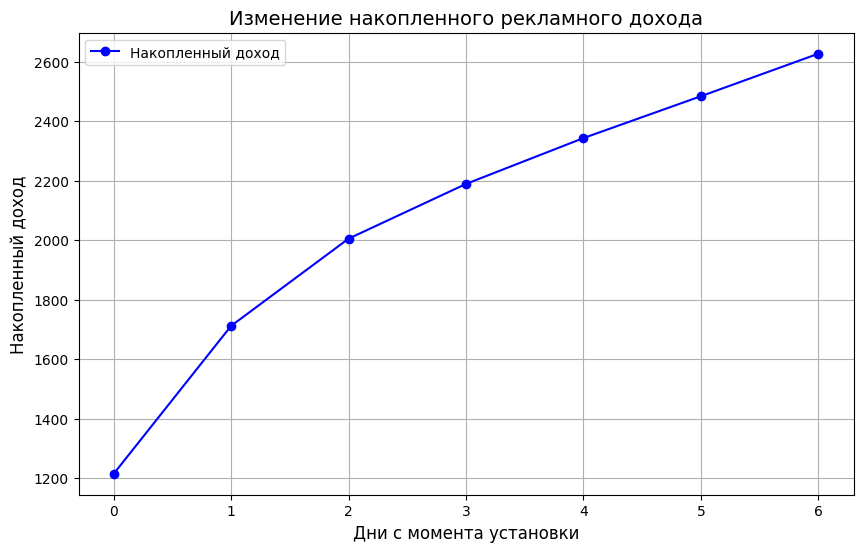

In [187]:
plt.figure(figsize=(10, 6))
plt.plot(daily_revenue.days_since_install, daily_revenue.cumulative_revenue, marker='o', color='b', label='Накопленный доход')

plt.title('Изменение накопленного рекламного дохода', fontsize=14)
plt.xlabel('Дни с момента установки', fontsize=12)
plt.ylabel('Накопленный доход', fontsize=12)

plt.grid(True)
plt.legend()

plt.show()

Рост накопленного дохода не линейный, на графике наглядно видно, что регрессия логарифмическая

Поэтому будем использовать логарифмическую функцию для прогноза

In [179]:
def revenue_growth(days, a, b, c):
    return a * np.log(b * days + 1) + c

Подготовим данные для моделирования: 'days_since_install' и 'cumulative_revenue' для первых 7 дней

In [180]:
x_data = daily_revenue['days_since_install']
y_data = daily_revenue['cumulative_revenue']

Проведем аппроксимацию модели методом наименьших квадратов

In [188]:
params, _ = curve_fit(revenue_growth, x_data, y_data, maxfev=10000)

c:\Program Files\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Сгенерируем предсказания для дней с 0 по 29 (30 дней сентября)

In [182]:
days = np.arange(0, 29)
predicted_revenue = revenue_growth(days, *params)

Расситаем накопленный доход для дня 30 и соотношение с днем установки (день 0)

In [183]:
cumulative_day_0 = predicted_revenue[0]
cumulative_day_30 = predicted_revenue[-1]
revenue_ratio = cumulative_day_30 / cumulative_day_0

cumulative_day_30, revenue_ratio

(np.float64(3639.118520306077), np.float64(2.988901555009412))

Результаты:

Прогнозируемый доход на 30-й день: 3639.12.
Доход на 30-й день в 2.99 раза больше дохода в день установки игры.